In [1]:
"""
This computes syntactic sieve scores for heads.
"""
import numpy as np
import pickle as pkl
import seaborn as sns
import tokenization
import matplotlib.pyplot as plt
import re
import spacy
import os
import scipy.stats as st
#!python3 -m spacy download en_core_web_sm

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [10]:
def init(task_name):
    """
    Set this to the path of the input sentences.
    """
    input_file = './texts/glue_data_{}_test_small.tsv'.format(task_name.upper())
    """
    Set this to the path of your attention weights file. Attention weights should be a 
    list of num_sents tensors each of size (12 ,12 ,128 ,128) [num_layer, num_heads, max_seq_len, max_seq_len].
    """
    attn_file1 = './pkl_dir/attention_weights_{}_small.pkl'.format(task_name)
    #attn_file2 = '../pkl_dir/attention_weights_{}_last500.pkl'.format(task_name)
    task_name=task_name
    
    # Read attention weights file.
    a = pkl.load(open(attn_file1, 'rb'))
    print("len of a {}".format(len(a)))
    print("shape of a {}".format(a[0].shape))
    
    # Read text file.
    f = open(input_file, 'r')
    f1 = f.readlines()
    f1 = f1[1:]   #Ignore the 1st row which has label.
    print("Total sentences in test set: {}".format(len(f1)))
    return f1, a

In [11]:
def cleanup(sent):
    s = re.findall(r"[\w']+|[.,!?;]", sent)
    return " ".join(s)

In [12]:
# p-val calculation
def ztest_own(pop1, th, n, alternate='smaller'):
    mu1, v = np.mean(pop1), np.std(pop1) 
    z = (mu1 - th)/(v/np.sqrt(n))
    #print("n here is {}".format(n))
    df = n - 1
    rv = st.t(df)
    if alternate == 'larger':
        return rv.cdf(z)
    else:
        #print('here')
        return 1 - rv.cdf(z)
    
def get_pvals(sent_set ,out_band, uniform_baseline_score):
    alt_pval = np.zeros([num_layers, num_heads])
    #print(len(out_band))
    #print(out_band[0].shape)
    for l in range(num_layers):
            for h in range(num_heads):
                single_head_scores, baseline_score = [], []
                for s in sent_set:
                    single_head_scores.append(out_band[s][l,h])
                    baseline_score.append(uniform_baseline_score[s])
#                 if l == 0 and h == 0:
#                     print("baseline pop size: {}".format(len(baseline_score)))
#                     print("head score pop size: {}".format(len(single_head_scores)))
                score = ztest_own(single_head_scores, baseline_score[0], len(single_head_scores))
                #score = ztest_own(single_head_scores, uniform_baseline_score, num_sents)
                alt_pval[l,h] = score
    return alt_pval

In [13]:
class tupl():
    def __init__(self, sent_num, sub_sent_num, w1, w2, reln):
        self.sent_num = sent_num
        self.sub_sent_num = sub_sent_num
        self.w1 = w1
        self.w2 = w2
        self.reln = reln
        
    def print_val(self):
        print(self.sent_num, self.sub_sent_num, self.w1, self.w2, self.reln)

In [14]:
class dataset():
    def __init__(self, doc):
        if task_name in ['qnli', 'qqp']:  #2 sentence task
            self.doc = []
            for d in doc:
                d = d.split('\t')
                idx, senta, sentb = d[0], d[1], d[2]
                clean_senta, clean_sentb = cleanup(senta), cleanup(sentb)
                #print(clean_senta)
                final_sent = idx + '\t' + clean_senta + '\t' + clean_sentb
                #print(final_sent)
                self.doc.append(final_sent)
        elif task_name in ['mrpc']:
            self.doc = []
            for d in doc:
                d = d.split('\t')
                idx, senta, sentb = d[0], d[3], d[4]
                clean_senta, clean_sentb = cleanup(senta), cleanup(sentb)
                #print(clean_senta)
                final_sent = idx + '\t' + clean_senta + '\t' + clean_sentb
                #print(final_sent)
                self.doc.append(final_sent)
        elif task_name in ['sst-2']:
            self.doc = []
            for d in doc:
                d = d.split('\t')
                idx, sent = d[0], d[1]
                clean_sent = cleanup(sent)
                #print(clean_senta)
                final_sent = idx + '\t' + clean_sent + '\t' + 'dummy text'
                #print(final_sent)
                self.doc.append(final_sent)
        else:
            self.doc = [cleanup(d) for d in doc]
            
        self.nlp = spacy.load('en_core_web_sm')
        self.all_tupl = []
        self.nsubj_tupl, self.dobj_tupl, self.advmod_tupl, self.amod_tupl = [], [], [], [] 
        self.tokenizer = tokenization.FullTokenizer(vocab_file="vocab.txt", do_lower_case=True)
        
    def print_doc(self):
        print(self.doc[:10])
        
        
    def parse_dep_relations(self):
        for line_num, line in enumerate(self.doc):
            #print(line)
            sent = line.split('\t')
            if task_name in  ['qnli', 'qqp', 'mrpc']:
                if task_name in ['qnli','qqp', 'mrpc']:
                    sent_a, sent_b = sent[1], sent[2]
                d1 = self.nlp(sent_a) 
                d2 = self.nlp(sent_b)
                for token in d1:
                    t1 = tupl(line_num, 'a', token.text, token.head.text, token.dep_)
                    self.all_tupl.append(t1)
                    if t1.reln == 'nsubj':
                        self.nsubj_tupl.append(t1)
                    elif t1.reln == 'dobj':
                        self.dobj_tupl.append(t1)
                    elif t1.reln == 'amod':
                        self.amod_tupl.append(t1)
                    elif t1.reln == 'advmod':
                        self.advmod_tupl.append(t1)
                    
                for token in d2:
                    t2 = tupl(line_num, 'b', token.text, token.head.text, token.dep_)
                    self.all_tupl.append(t2)
                    if t2.reln == 'nsubj':
                        self.nsubj_tupl.append(t2)
                    elif t2.reln == 'dobj':
                        self.dobj_tupl.append(t2)
                    elif t2.reln == 'amod':
                        self.amod_tupl.append(t2)
                    elif t2.reln == 'advmod':
                        self.advmod_tupl.append(t2)
            elif task_name in ['sst-2']:
                sent_a, sent_b = sent[1], sent[2]
                d1 = self.nlp(sent_a) 
                for token in d1:
                    t1 = tupl(line_num, 'a', token.text, token.head.text, token.dep_)
                    self.all_tupl.append(t1)
                    if t1.reln == 'nsubj':
                        self.nsubj_tupl.append(t1)
                    elif t1.reln == 'dobj':
                        self.dobj_tupl.append(t1)
                    elif t1.reln == 'amod':
                        self.amod_tupl.append(t1)
                    elif t1.reln == 'advmod':
                        self.advmod_tupl.append(t1)
                
    def print_all_tupls(self):
        for t in self.all_tupl:
            t.print_val()
    def get_all_tupls(self):
        return self.all_tupl
    
    def get_all_tupls_by_reln(self, dep_reln):
        all_tupl_dep_reln = []
        for t in self.all_tupl:
            if t.reln == dep_reln:
                all_tupl_dep_reln.append(t)
        return all_tupl_dep_reln
    
    def get_distance(self, w1, w2, sent):
        sent1 = sent.split()
        if w1 in sent1 and w2 in sent1:
            distance = sent1.index(w1) - sent1.index(w2)
            return distance
        else:
            #print(sent1)
            #print(w1, w2)
            #print("words not in sentence.")
            return float("inf")
        
    def get_data_for_pred(self, reln):
        if reln == 'nsubj':
            data = self.nsubj_tupl
        elif reln == 'amod':
            data = self.amod_tupl
        elif reln == 'advmod':
            data = self.advmod_tupl
        elif reln == 'dobj':
            data = self.dobj_tupl
        #print('here')
        #[d.print_val() for d in data]
        #print('over')
        final_data_for_pred = []
        for t in data:
            sent_num = t.sent_num
            sub_sent_num = t.sub_sent_num
            w1, w2 = t.w1, t.w2
            w1_tok, w2_tok = self.tokenizer.tokenize(w1), self.tokenizer.tokenize(w2)
            sent = self.doc[sent_num]
            sent = sent.split('\t')
            if task_name in  ['qqp', 'qnli', 'mrpc']:
                final_sent = ['CLS'] + self.tokenizer.tokenize(sent[1]) + ['SEP'] + self.tokenizer.tokenize(sent[2]) + ['SEP']
            elif task_name in ['sst-2']:
                final_sent = ['CLS'] + self.tokenizer.tokenize(sent[1]) + ['SEP']
            #print(final_sent)
            #print(w1,w2)
            w1_idx, w2_idx = [], []
            if sub_sent_num == 'a':
                try:
                    w1_idx = [final_sent.index(x) for x in w1_tok]
                    w2_idx = [final_sent.index(x) for x in w2_tok]
                except ValueError:
                    print('not found in list.')
                    continue
                sent = sent[1]
            else:
                senta_tok, sentb_tok = self.tokenizer.tokenize(sent[1]), self.tokenizer.tokenize(sent[2])
                try:
                    w1_idx = [sentb_tok.index(x) for x in w1_tok]
                    w2_idx = [sentb_tok.index(x) for x in w2_tok]
                except ValueError:
                    print('not found in list.')
                    continue
                w1_idx = [x + len(senta_tok) + 2 for x in w1_idx]
                w2_idx = [x + len(senta_tok) + 2 for x in w2_idx]
                sent = sent[2]
                
            if self.get_distance(w1, w2, sent) != float("inf") and all(x < max_seq_len for x in w1_idx) and all(x < max_seq_len for x in w2_idx):
                final_data_for_pred.append({"w1":w1, "w2":w2, "sent":" ".join(final_sent),"sent_num":sent_num, "sub_sent_num":sub_sent_num, "w1_idx":w1_idx,"w2_idx":w2_idx ,"label":True})
            # condiser mixing false exampels as well.?
        return final_data_for_pred
                
    
    def plot_distbn_by_reln(self, all_tupl_dep_reln):
        distance_vec = []
        for t in all_tupl_dep_reln:
            sent_num = t["sent_num"]
            sub_sent_num = t["sub_sent_num"]
            w1, w2 = t["w1"], t["w2"]
            #print(w1,w2)
            
            sent = self.doc[sent_num]
            sent = sent.split('\t')
            if sub_sent_num == 'a':
                sent = sent[1]
            else:
                sent = sent[2]
                
            distance = self.get_distance(w1, w2, sent)
            if distance != float("inf"):
                distance_vec.append(distance)
        
        #Plot
        #bins = np.arange(-6,6,1) - 0.5
        #plt.hist(distance_vec, bins, ec="black")
        sns.distplot(distance_vec, hist=True, kde=False, bins=50)
        plt.xlim(-5,5)
        return distance_vec
        #plt.hist(distance_vec,color = "skyblue", ec="black")    

In [15]:
class Heads1():
    def __init__(self, attn_wts, doc_data, task_name):
        self.attn_wts = attn_wts
        self.doc_data = doc_data
        self.score = np.zeros([num_sents,num_layers, num_heads])
        self.tokenizer = tokenization.FullTokenizer(vocab_file="vocab.txt", do_lower_case=True)
        #self.map = np.zeros([num_sents])
        #self.participating_sents = set()
        self.baseline_score = np.zeros([num_sents])
        self.task_name = task_name
        
    def get_score(self, dep_reln_list, direction='l2r', baseline='random'):
        
        map1 = np.zeros([num_sents])
        participating_sents = set()
        self.score = np.zeros([num_sents,num_layers, num_heads])
        
        for single_tupl in dep_reln_list:
            sent_idx = single_tupl["sent_num"]
            w1, w2 = single_tupl["w1"], single_tupl["w2"]
            sub_sent_num = single_tupl["sub_sent_num"]
            #reln = single_tupl.reln
            sent = self.doc_data.doc[sent_idx].split('\t')
            #print(sent)
            sent_a = self.tokenizer.tokenize(sent[1])
            sent_b = self.tokenizer.tokenize(sent[2])
            final_sent = ['CLS '] + sent_a + [' SEP '] + sent_b + [' SEP']
            if self.task_name == 'sst-2':
                final_sent = ['CLS '] + sent_a + [' SEP ']
            sent_len = min(128,len(final_sent))
            #print(sent_len)
            #w1_tok, w2_tok = self.tokenizer.tokenize(w1), self.tokenizer.tokenize(w2)
            w1_idx, w2_idx = single_tupl["w1_idx"], single_tupl["w2_idx"]
            
            map1[sent_idx] += 1
            participating_sents.add(sent_idx)
           
                
            #print(w1_tok)
            #print(w2_tok)
            #print(sent_idx, sub_sent_num)
            #print(final_sent)
            for l in range(num_layers):
                for h in range(num_heads):
                    #print(i,l,h)
                    attn_per_head = self.attn_wts[sent_idx][l,h, :sent_len, :sent_len]
                    token_score=0
                    w1_total = 0
                    # Calc attn(w1->w2)
                    for id1 in w1_idx:
                        partial_tok_score = 0
                        w1_total += np.sum(attn_per_head[id1,:])
                        for id2 in w2_idx:
                            part_attn = attn_per_head[id1, id2]
                            partial_tok_score += part_attn
                        partial_tok_score = partial_tok_score/len(w2_idx)
                        
                        token_score += partial_tok_score
                    w1_w2_attention = token_score/len(w1_idx)
                    w1_total /= len(w1_idx)
                    w1_total /= sent_len
                    
#                     if l==0 and h==0 and sent_idx==3:
#                         print("w1_w2_attention: {}".format(w1_w2_attention))
#                         print("w1_total: {}".format(w1_total))
                    
                    # Calc w2->w1 attention.
                    token_score=0
                    w2_total = 0
                    for id2 in w2_idx:
                        partial_tok_score = 0
                        #if l==0 and h==0:
                        #    print('tok1 idx {}'.format(id1))
                        w2_total += np.sum(attn_per_head[id2,:])
                        for id1 in w1_idx:
                          #   if l==0 and h==0:
                          #      print('tok2 idx {}'.format(id2))
                            part_attn = attn_per_head[id2, id1]
                            partial_tok_score += part_attn
                        partial_tok_score = partial_tok_score/len(w1_idx)
                        
                        token_score += partial_tok_score
                    w2_w1_attention = token_score/len(w2_idx)
                    w2_total /= len(w2_idx)
                    w2_total /= sent_len
#                     if l==0 and h==0 and sent_idx==3:
#                         print("w2_w1_attention: {}".format(w2_w1_attention))
#                         print("w2_total: {}".format(w2_total))
                    
                    if direction == 'l2r':
                        token_score = w1_w2_attention/w1_total
                    elif direction == 'r2l':
                        token_score = w2_w1_attention/w2_total
                    elif direction == 'bi':
                        token_score = ((w1_w2_attention/w1_total)+(w2_w1_attention/w2_total))/2
                        
                    
                    self.score[sent_idx, l, h] += token_score
#                     if token_score > 2 and l == 0 and h == 11:
#                         print(single_tupl)

        for i,x in enumerate(map1):
            if x != 0:
                self.score[i, :, :] /= x
                self.baseline_score[i] = 1
                
        return self.score,  self.baseline_score, participating_sents

In [16]:
# save the calculated syntactic sieve scores, and also the corresponding sentences.
def vis_and_save(score,pvals, participating_sents, reln, task_name, output_dir):  #reln=nsubj, dobj, amod, advmod, all
    plt.figure(figsize=(8,6))
    avged_score = np.sum(score, axis=0)/len(participating_sents)
    g = sns.heatmap(avged_score, cmap='Blues', annot=True)
    g.set(xticklabels=np.arange(12), yticklabels=np.arange(12))
    plt.xlabel('heads')
    plt.ylabel('layers')
    plt.title("{}:Avg syntactic score for {}".format(reln, task_name))
    plt.figure(figsize=(8,6))
    g = sns.heatmap(np.array(np.round(pvals,2)), annot=True, center=0.05)
    g.set(xticklabels=np.arange(12), yticklabels=np.arange(12))
    plt.xlabel('heads')
    plt.ylabel('layers')
    plt.title("{}: p-value for {} in 1x".format(reln, task_name))
    head_frac_syn = len([x for x in np.reshape(pvals, [num_layers*num_heads,]) if x < 0.05])/(num_heads*num_layers)
    #print("{}: Fraction of heads rejecting null hypothesis for {}: {}".format(reln, task_name, head_frac_syn))
    rej_heads = [i for i,x in enumerate(np.reshape(pvals, [num_layers*num_heads,])) if x < 0.05]
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    pkl.dump(participating_sents, open(output_dir + "{}_participating_sents_{}.pkl".format(reln, task_name), "wb"))
    pkl.dump(score, open(output_dir + "{}_all_heads_all_scores_{}.pkl".format(reln, task_name), "wb"))

len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
NSUBJ: Avg relation pairs per sentence:44
DOBJ: Avg relation pairs per sentence:24
AMOD: Avg relation pairs per sentence:54
ADVMOD: Avg relation pairs per sentence:18
ALL: Avg relation pairs per sentence:140
len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
NSUBJ: Avg relation pairs per sentence:49
DOBJ: Avg relation pairs per sentence:19
AMOD: Avg relation pairs per sentence:21
ADVMOD: Avg relation pairs per sentence:30
ALL: Avg relation pairs per sentence:119
len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
NSUBJ: Avg relation pairs per sentence:63
DOBJ: Avg relation pairs per sentence:33
AMOD: Avg relation pairs per sentence:52
ADVMOD: Avg relation pairs per sentence:26
ALL: Avg relation pairs per sentence:174


/home/attentionresearch/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


len of a 20
shape of a (12, 12, 128, 128)
Total sentences in test set: 20
NSUBJ: Avg relation pairs per sentence:25
DOBJ: Avg relation pairs per sentence:19
AMOD: Avg relation pairs per sentence:31
ADVMOD: Avg relation pairs per sentence:14
ALL: Avg relation pairs per sentence:89


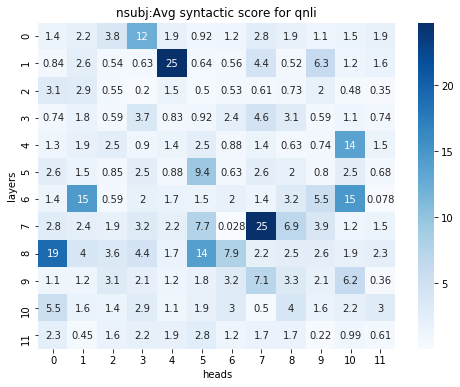

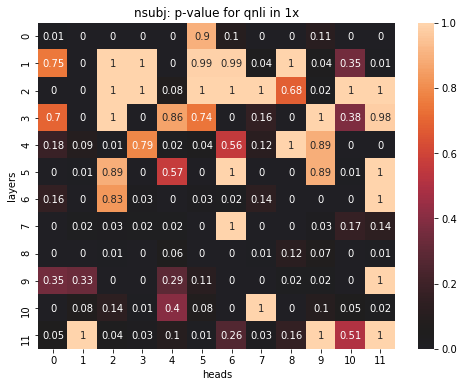

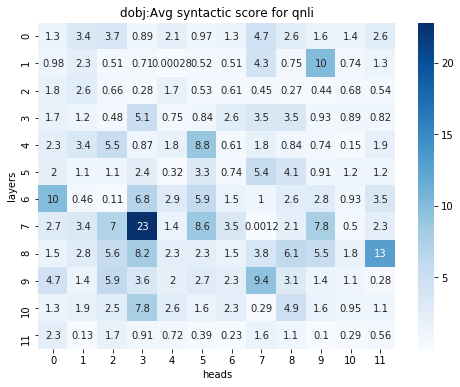

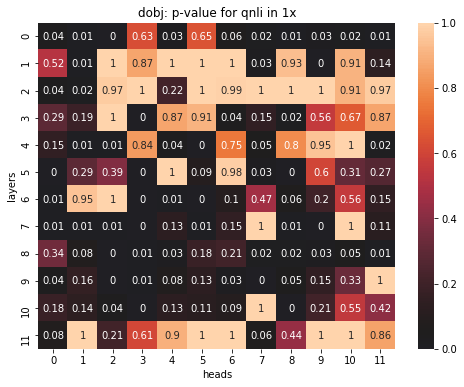

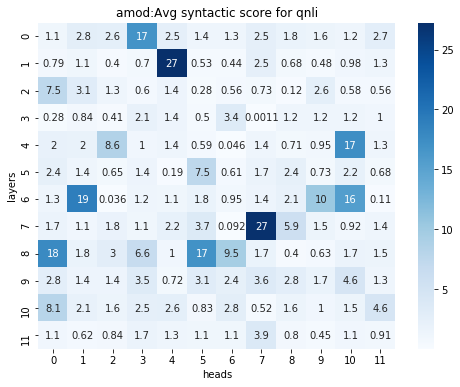

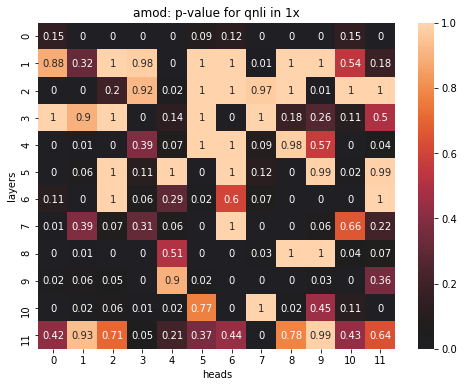

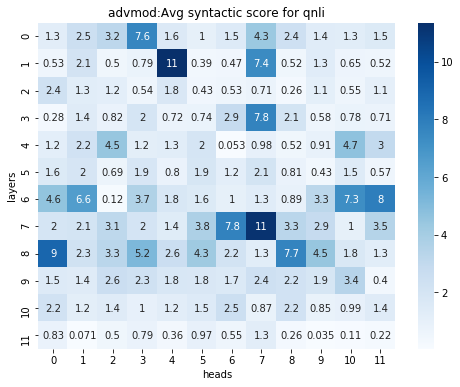

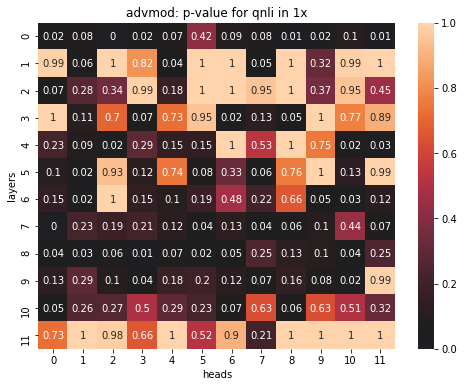

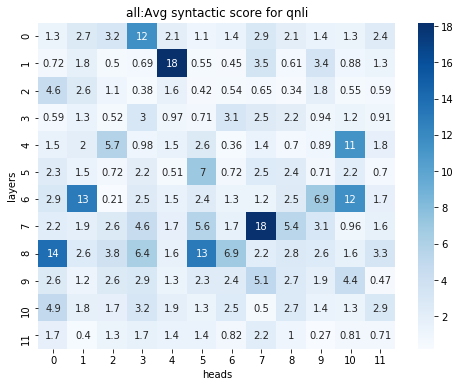

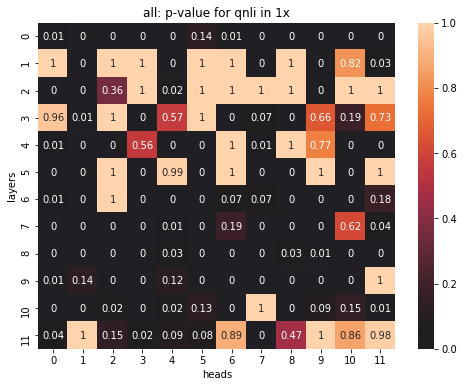

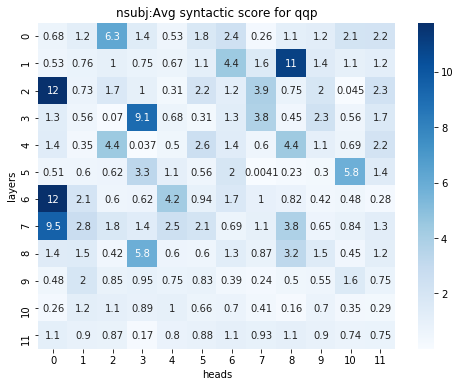

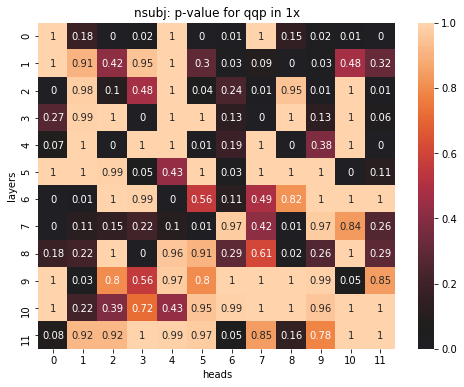

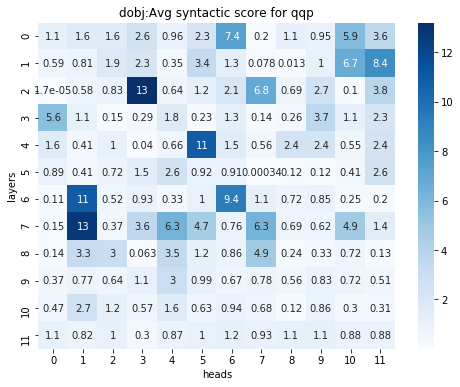

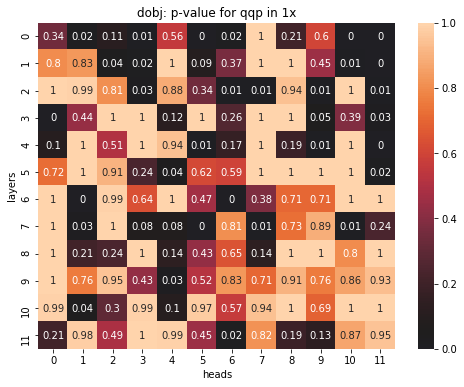

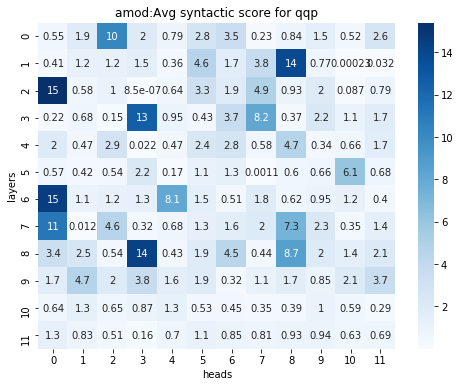

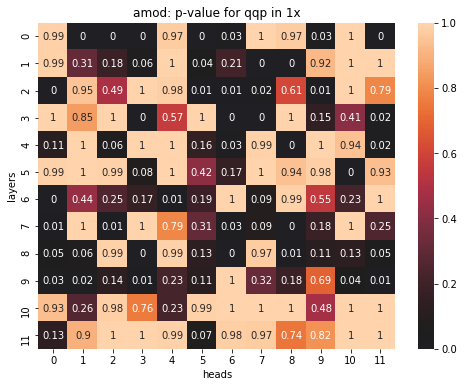

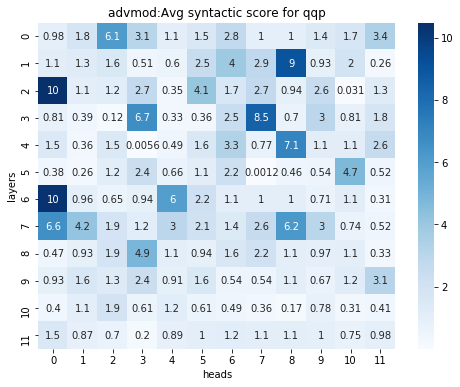

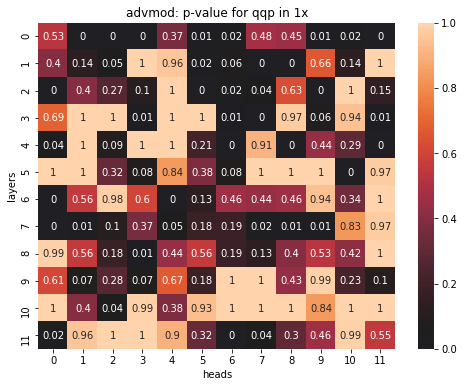

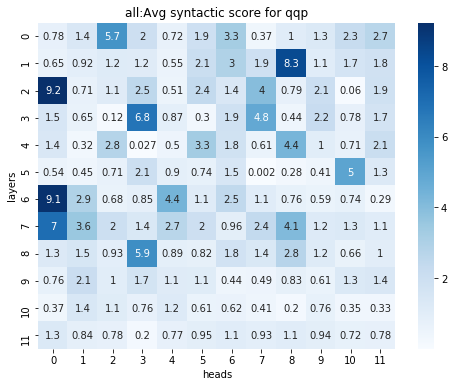

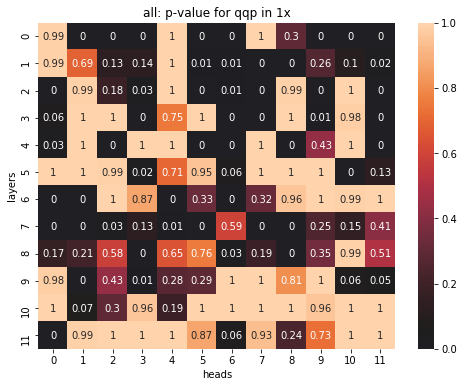

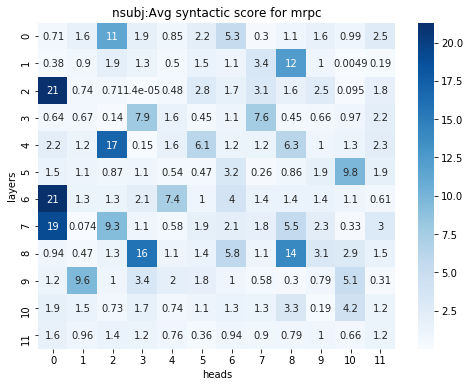

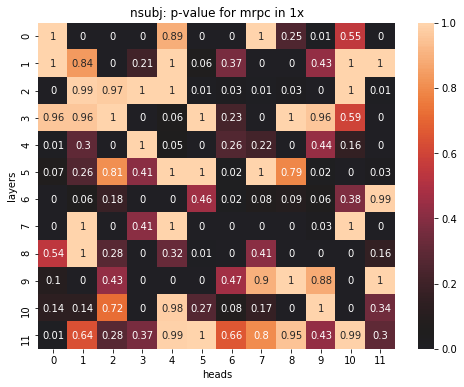

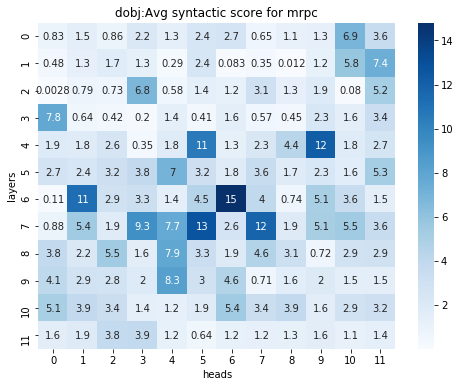

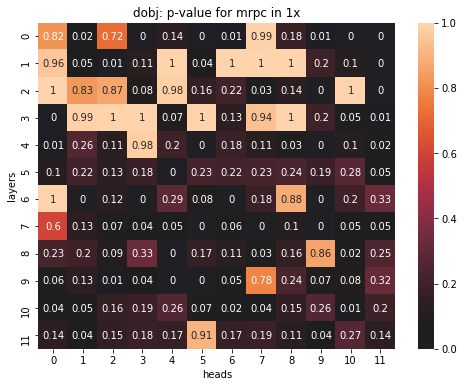

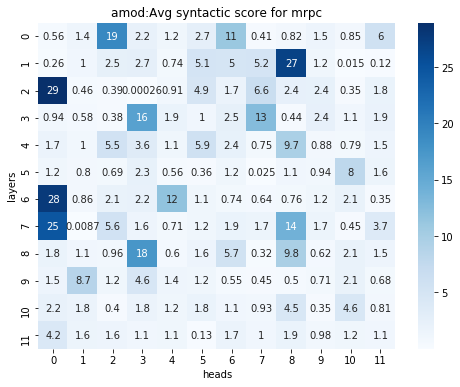

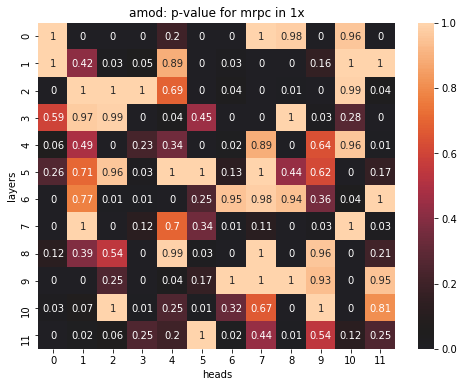

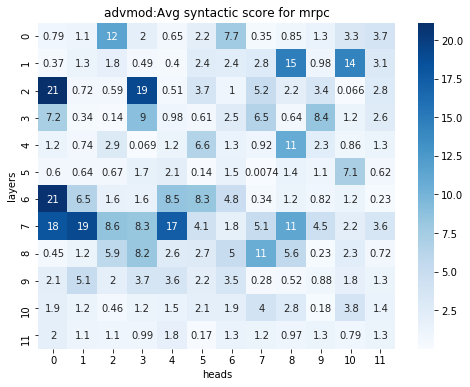

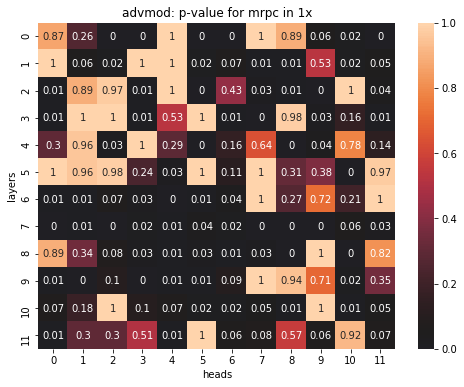

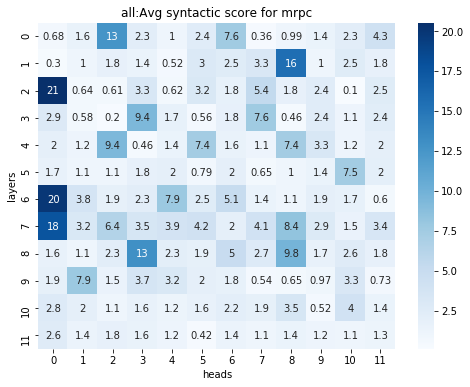

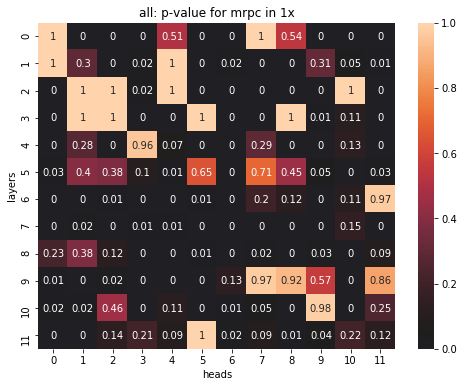

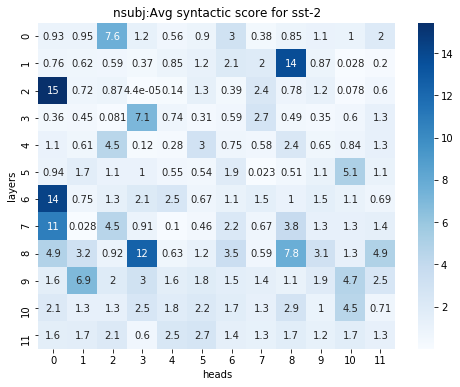

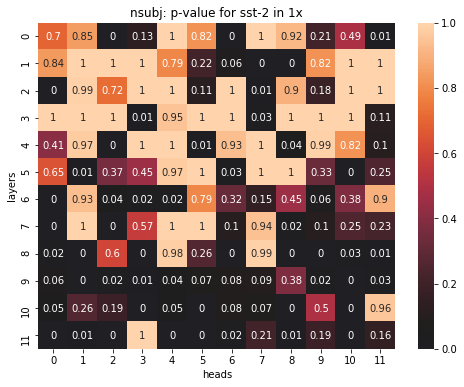

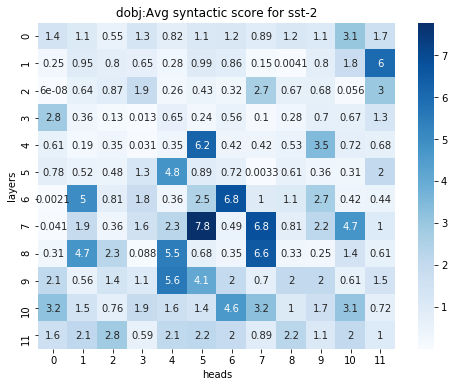

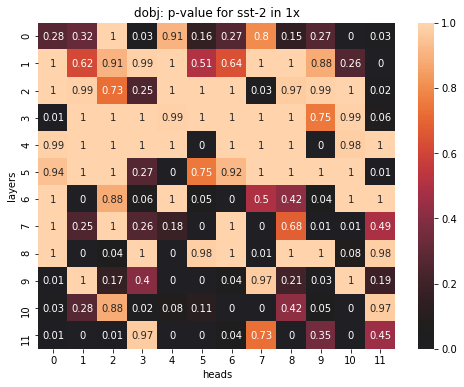

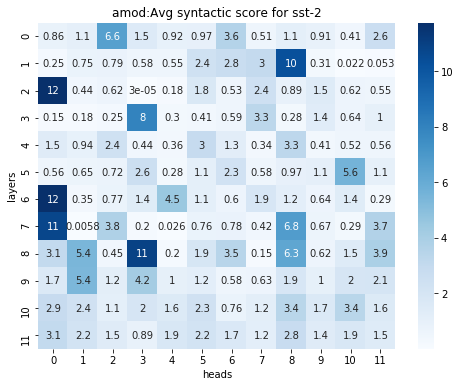

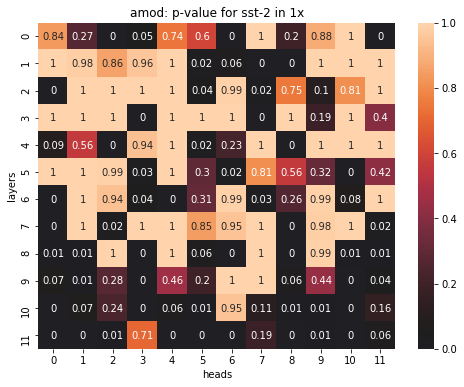

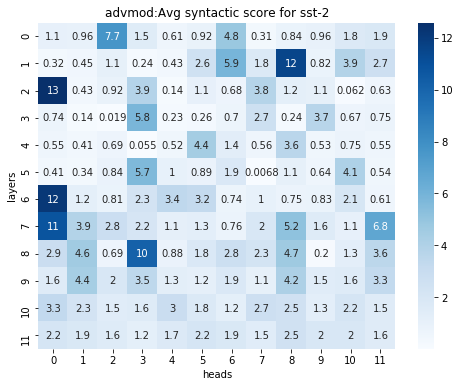

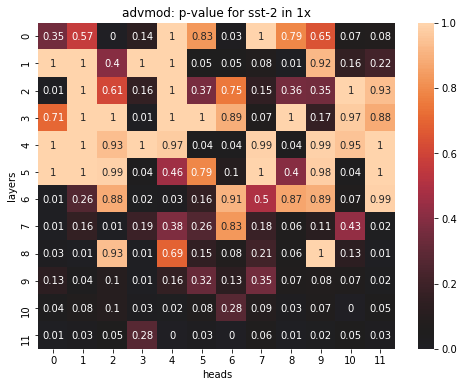

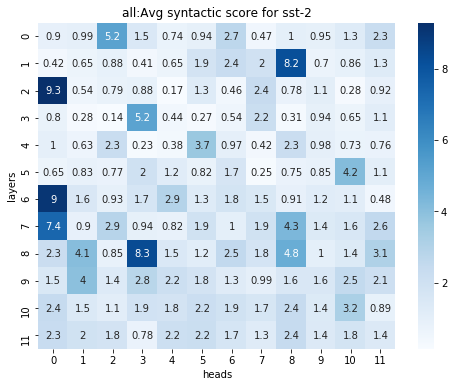

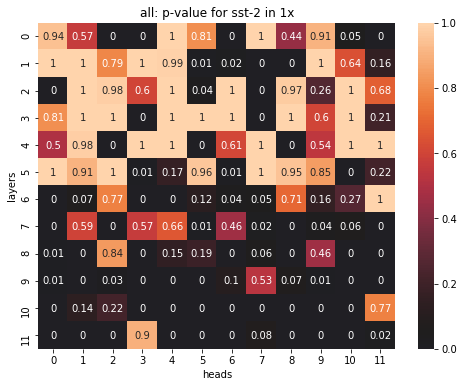

In [17]:
for task_name in ['qnli', 'qqp', 'mrpc', 'sst-2']:
    
    # This frees memory of unrequired variables in each iteration.
    %reset_selective -f "^a$"
    %reset_selective -f "^a1$"
    %reset_selective -f "^a2$"
    %reset_selective -f "^nsubj_data$"
    %reset_selective -f "^dobj_data$"
    %reset_selective -f "^amod_data$"
    %reset_selective -f "^advmod_data$"
    %reset_selective -f "^all_data$"
    %reset_selective -f "^score_nsubj$"
    %reset_selective -f "^score_dobj$"
    %reset_selective -f "^score_amod$"
    %reset_selective -f "^score_advmod$"
    %reset_selective -f "^participating_sents_nsubj$"
    %reset_selective -f "^participating_sents_dobj$"
    %reset_selective -f "^participating_sents_amod$"
    %reset_selective -f "^participating_sents_advmod$"
    %reset_selective -f "^h1$"
    %reset_selective -f "^baseline_score$"
    %reset_selective -f "^pvals$"
    %reset_selective -f "^d$"
    
    
    num_sents = 20  # Change this to number of sentences considered.
    num_layers, num_heads = 12, 12
    max_seq_len = 128
    output_dir = "./sieve_scores/syntactic/"
    
    # Initialize
    f1, a = init(task_name)
    
    # Set the data/text 
    d = dataset(f1[:num_sents])
    
    # Dependency parsing of the data.
    d.parse_dep_relations()
    nsubj_data = d.get_data_for_pred("nsubj")
    dobj_data = d.get_data_for_pred("dobj")
    amod_data = d.get_data_for_pred("amod")
    advmod_data = d.get_data_for_pred("advmod")
    all_data = nsubj_data + dobj_data + amod_data + advmod_data
    
    # relations of each type
    print("NSUBJ: Avg relation pairs per sentence:{}".format(len(nsubj_data)))
    print("DOBJ: Avg relation pairs per sentence:{}".format(len(dobj_data)))
    print("AMOD: Avg relation pairs per sentence:{}".format(len(amod_data)))
    print("ADVMOD: Avg relation pairs per sentence:{}".format(len(advmod_data)))
    print("ALL: Avg relation pairs per sentence:{}".format(len(all_data)))
    
    h1 = Heads1(a, d, task_name)
    #nsubj
    #print(nsubj_data)
    score_nsubj, baseline_score, participating_sents_nsubj = h1.get_score(nsubj_data)
#     print(len(participating_sents_nsubj))
#     print(len(set(participating_sents_nsubj)))
    pvals = get_pvals(participating_sents_nsubj, score_nsubj, baseline_score)
    vis_and_save(score_nsubj, pvals, participating_sents_nsubj, "nsubj", task_name, output_dir)
    
    #dobj
    score_dobj, baseline_score, participating_sents_dobj = h1.get_score(dobj_data)
#    print(len(participating_sents_dobj))
    pvals = get_pvals(participating_sents_dobj, score_dobj, baseline_score)
    vis_and_save(score_dobj, pvals, participating_sents_dobj, "dobj", task_name, output_dir)
    
    #amod
    score_amod, baseline_score, participating_sents_amod = h1.get_score(amod_data)
#    print(len(participating_sents_amod))
    pvals = get_pvals(participating_sents_amod, score_amod, baseline_score)
    vis_and_save(score_amod, pvals, participating_sents_amod, "amod", task_name, output_dir)
    
    #advmod
    score_advmod, baseline_score, participating_sents_advmod = h1.get_score(advmod_data)
#    print(len(participating_sents_advmod))
    pvals = get_pvals(participating_sents_advmod, score_advmod, baseline_score)
    vis_and_save(score_advmod, pvals, participating_sents_advmod, "advmod", task_name, output_dir)
    
    #all
    score_all, baseline_score, participating_sents_all = h1.get_score(all_data)
#    print(len(participating_sents_all))
    pvals = get_pvals(participating_sents_all, score_all, baseline_score)
    vis_and_save(score_all, pvals, participating_sents_all, "all", task_name, output_dir)